# Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os 
import glob as gb 
from tqdm.auto import tqdm

import torch 
import torch.nn as nn 
from torch.optim import Adam 
import torchvision 
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader , Dataset
from torchvision.utils import make_grid
from torchinfo import summary 

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
def show_tensor_images(axs , image_tensor , title , num_images=15):

    image_tensor = image_tensor * 0.5 + 0.5
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=3)
    axs.imshow(image_grid.permute(1, 2, 0).squeeze())
    axs.axis('off')
    axs.set_title(title)

# Loading our dataset & Turning our data into tensors

In [4]:
IMG_SIZE = 256
BATCH_SIZE = 32
IMG_DIR = '/kaggle/input/ham1000-segmentation-and-classification/masks' 
MASK_DIR = '/kaggle/input/ham1000-segmentation-and-classification/images'

In [5]:
class InvalidDatasetException(Exception):
    
    def __init__(self,len_of_paths,len_of_labels):
        super().__init__(
            f"Number of paths ({len_of_paths}) is not compatible with number of labels ({len_of_labels})"
        )

In [6]:
class CustomData(Dataset) : 
    def __init__(self , img_dir , mask_dir) : 
        self.imgs_path = sorted(gb.glob(os.path.join(img_dir , '*.png')))
        self.masks_path = sorted(gb.glob(os.path.join(mask_dir , '*.jpg'))) 
        self.transform = transforms.Compose([
            transforms.Resize(size = (IMG_SIZE , IMG_SIZE)) , 
            ToTensor() , 
        ]) 
        if len(self.imgs_path) != len(self.masks_path) : 
            raise InvalidDatasetException(self.imgs_path , self.masks_path) 
            
    def __len__(self) : 
        return len(self.imgs_path)
    
    def __getitem__(self , idx) : 
        img = Image.fromarray(cv2.cvtColor(cv2.imread(self.imgs_path[idx]) , cv2.COLOR_BGR2RGB)) 
        img = self.transform(img)
        
        mask = Image.open(self.masks_path[idx])
        mask = self.transform(mask) 
        
        return img , mask

In [7]:
dataset = CustomData(IMG_DIR , MASK_DIR)

In [8]:
print(f"The total number of samples in the dataset is : {dataset.__len__()}")

The total number of samples in the dataset is : 10015


# Create DataLoaders

In [9]:
dataset_dataloader = DataLoader(
    dataset = dataset , 
    batch_size = BATCH_SIZE , 
    shuffle = True , 
    num_workers=4 , 
    pin_memory = True
)

In [10]:
print(f"the size of the dataloader {len(dataset_dataloader)} batches of {BATCH_SIZE}")

the size of the dataloader 313 batches of 32


In [11]:
img_samples , mask_samples= next(iter(dataset_dataloader))
img_samples.shape , mask_samples.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32, 3, 256, 256]))

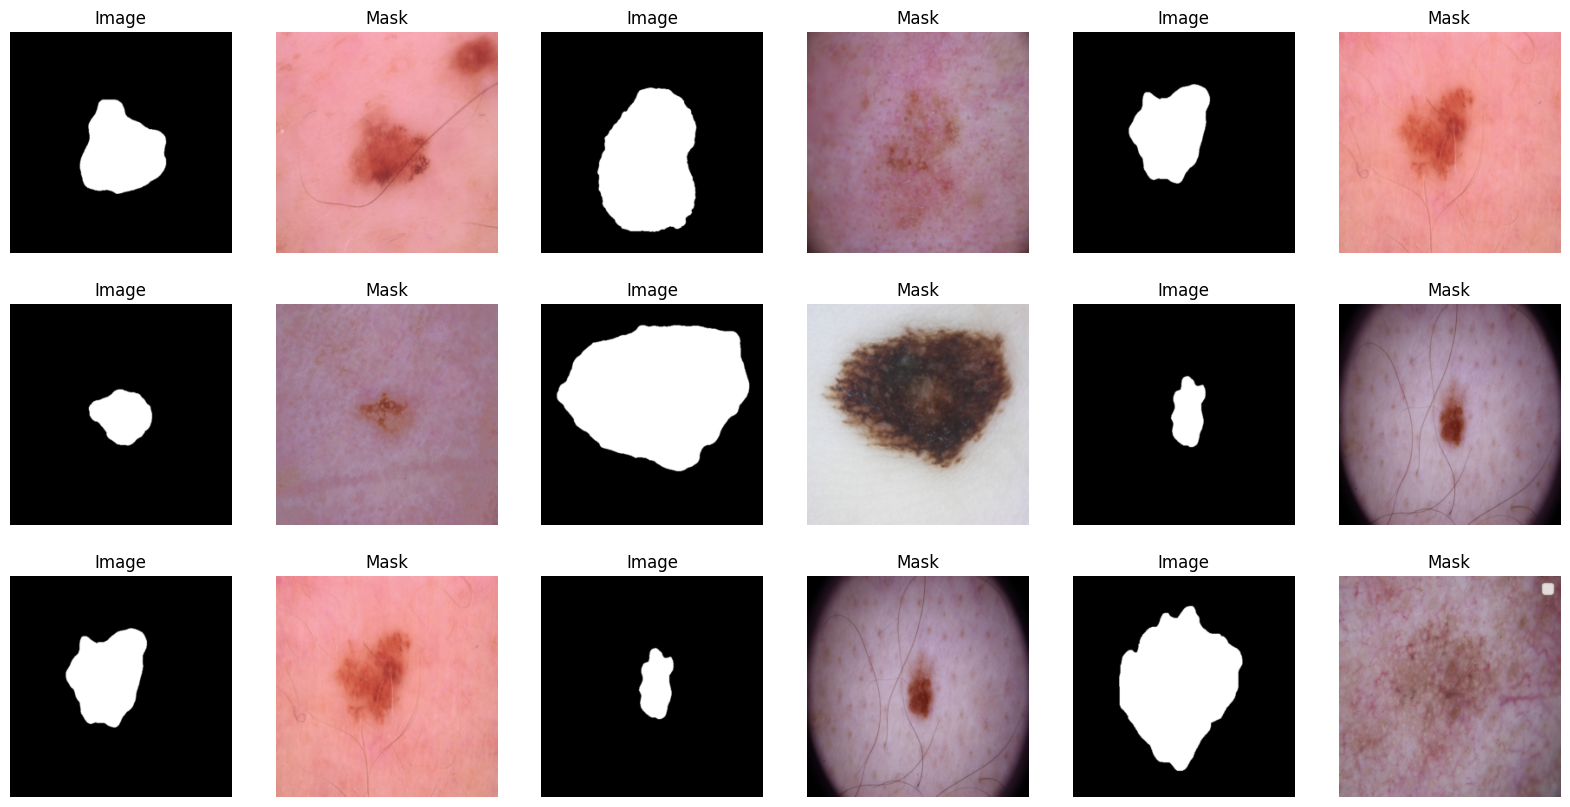

In [12]:
def plot_samples(img_samples , mask_samples):
    
    plt.figure(figsize = (20, 10))
    index = 0
    n = np.random.randint(img_samples.shape[0])
    for i in range(18):
        plt.subplot(3, 6, (i + 1))
        if index == 0:
            img = img_samples[n].numpy()
            img = np.transpose(img , (1 , 2 , 0))
            plt.imshow(img)
            plt.title('Image')
            index = 1
            plt.axis('off')
        elif index == 1:
            mask = mask_samples[n].numpy()
            mask = np.transpose(mask , (1 , 2 , 0))
            plt.imshow(mask)
            plt.title('Mask')
            index = 0
            plt.axis('off')
            n = np.random.randint(img_samples.shape[0])
            
    plt.legend()
    
plot_samples(img_samples , mask_samples)

# Build our model

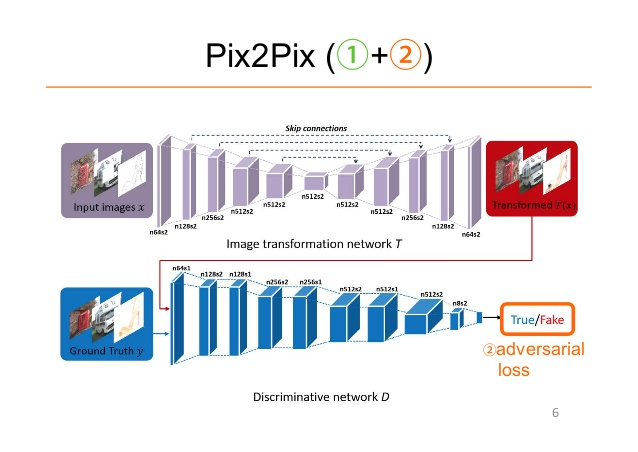

**The Discriminator**

In [13]:
class Discriminator(nn.Module) : 
    def __init__(self , in_channels = 3) : 
        super(Discriminator , self).__init__() 
        self.block = nn.Sequential(
            self.disc_block(in_channels * 2 , 64 , initial_layer=True) , 
            self.disc_block(64 , 128) , 
            self.disc_block(128 , 256) , 
            self.disc_block(256 , 512) , 
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )
        
    def disc_block(self , input_channels , output_channels , initial_layer = False) : 
        if not initial_layer : 
            return nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = 4 , 
                    stride = 2 , 
                    padding = 1 , 
                    bias = False
                ) , 
                nn.BatchNorm2d(output_channels) , 
                nn.LeakyReLU(0.2)
            )
        
        else : 
            return nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = 4 , 
                    stride = 2 , 
                    padding = 1 , 
                    bias = False 
                ) , 
                nn.LeakyReLU(0.2)
            )
        
    def forward(self , img0 , img1) : 
        img_input = torch.cat((img0 , img1) , dim = 1) 
        return self.block(img_input)

**The Generator**

In [14]:
class Encoder(nn.Module) : 
    def __init__(self , input_channels , output_channels , norm_layer = False , use_dropout = False) : 
        super(Encoder , self).__init__() 
        if not norm_layer : 
            self.block = nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = 4 , 
                    stride = 2 , 
                    padding = 1 , 
                    bias = False
                ) , 
                nn.BatchNorm2d(output_channels) , 
                nn.LeakyReLU(0.2)
            )
            
        else : 
            self.block = nn.Sequential(
                nn.Conv2d(
                    input_channels , 
                    output_channels , 
                    kernel_size = 4 , 
                    stride = 2 , 
                    padding = 1 , 
                    bias = False
                ) , 
                nn.LeakyReLU(0.2)
            )
            
        self.use_dropout = use_dropout 
        self.dropout = nn.Dropout(0.5)
        
    def forward(self , x) : 
        x = self.block(x) 
        
        return self.dropout(x) if self.use_dropout else x

In [15]:
class Decoder(nn.Module) : 
    def __init__(self , input_channels , output_channels , use_dropout = False) : 
        super(Decoder , self).__init__() 
        self.block = nn.Sequential(
            nn.ConvTranspose2d(
                input_channels , 
                output_channels , 
                kernel_size = 4 , 
                stride = 2 ,
                padding = 1 , 
                bias = False
            ) , 
            nn.BatchNorm2d(output_channels) , 
            nn.ReLU(inplace=True)
        )
        
        self.use_dropout = use_dropout 
        self.dropout = nn.Dropout(0.5)
        
    def forward(self , x , skip_connection) : 
        x = self.block(x) 
        
        x = torch.cat([x , skip_connection] , dim = 1) 
        
        return self.dropout(x) if self.use_dropout else x

In [16]:
class Generator(nn.Module) : 
    def __init__(self , in_channels = 3 , out_channels = 3) : 
        super(Generator , self).__init__() 
        
        # encoder 
        self.down1 = Encoder(in_channels , 64 , norm_layer = True)
        self.down2 = Encoder(64 , 128)
        self.down3 = Encoder(128 , 256)
        self.down4 = Encoder(256 , 512 , use_dropout=True)
        self.down5 = Encoder(512 , 512 , use_dropout=True)
        self.down6 = Encoder(512 , 512 , use_dropout=True)
        self.down7 = Encoder(512 , 512 , use_dropout=True)
        self.down8 = Encoder(512 , 512 , norm_layer = True , use_dropout=True) 
        
        # decoder 
        self.up1 = Decoder(512 , 512 , use_dropout=True)
        self.up2 = Decoder(1024 , 512 , use_dropout=True)
        self.up3 = Decoder(1024 , 512 , use_dropout=True)
        self.up4 = Decoder(1024 , 512 , use_dropout=True)
        self.up5 = Decoder(1024, 256)
        self.up6 = Decoder(512, 128)
        self.up7 = Decoder(256, 64)
        
        self.final_conv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final_conv(u7)

In [17]:
disc_model = Discriminator().to(device)
gen_model = Generator().to(device)

In [18]:
dummy_img = torch.randn((BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)).to(device)
dummy_mask = torch.randn((BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE)).to(device)

In [19]:
summary(disc_model , input_data = [dummy_img , dummy_mask])

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [32, 1, 16, 16]           --
├─Sequential: 1-1                        [32, 1, 16, 16]           --
│    └─Sequential: 2-1                   [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 64, 128, 128]        6,144
│    │    └─LeakyReLU: 3-2               [32, 64, 128, 128]        --
│    └─Sequential: 2-2                   [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-3                  [32, 128, 64, 64]         131,072
│    │    └─BatchNorm2d: 3-4             [32, 128, 64, 64]         256
│    │    └─LeakyReLU: 3-5               [32, 128, 64, 64]         --
│    └─Sequential: 2-3                   [32, 256, 32, 32]         --
│    │    └─Conv2d: 3-6                  [32, 256, 32, 32]         524,288
│    │    └─BatchNorm2d: 3-7             [32, 256, 32, 32]         512
│    │    └─LeakyReLU: 3-8               [32, 256, 32, 32]         --


In [20]:
summary(gen_model , input_data = dummy_img)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [32, 3, 256, 256]         --
├─Encoder: 1-1                           [32, 64, 128, 128]        --
│    └─Sequential: 2-1                   [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 64, 128, 128]        3,072
│    │    └─LeakyReLU: 3-2               [32, 64, 128, 128]        --
├─Encoder: 1-2                           [32, 128, 64, 64]         --
│    └─Sequential: 2-2                   [32, 128, 64, 64]         --
│    │    └─Conv2d: 3-3                  [32, 128, 64, 64]         131,072
│    │    └─BatchNorm2d: 3-4             [32, 128, 64, 64]         256
│    │    └─LeakyReLU: 3-5               [32, 128, 64, 64]         --
├─Encoder: 1-3                           [32, 256, 32, 32]         --
│    └─Sequential: 2-3                   [32, 256, 32, 32]         --
│    │    └─Conv2d: 3-6                  [32, 256, 32, 32]         524,288
│

# Train our model

In [21]:
disc_optimizer = Adam(disc_model.parameters() , lr = 0.0002, betas=(0.5 , 0.999))
gen_optimizer = Adam(gen_model.parameters() , lr = 0.0002 , betas=(0.5 , 0.999))
criterion = nn.BCEWithLogitsLoss() 
criterion_pixelwise = nn.L1Loss() 
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
lambda_pixel = 100
Epochs = 100

  0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 10/100] [Disc loss: 0.533783] [Gen loss: 12.072689]


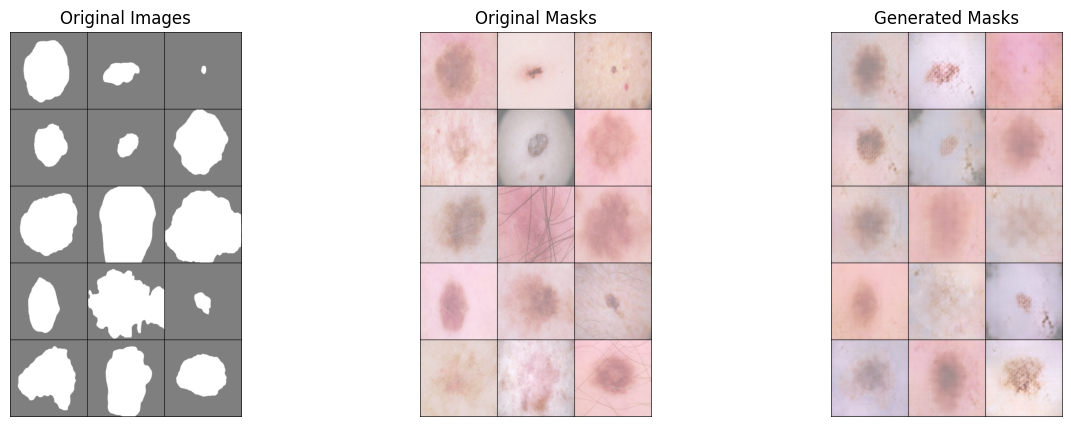

[Epoch 20/100] [Disc loss: 0.640188] [Gen loss: 11.750479]


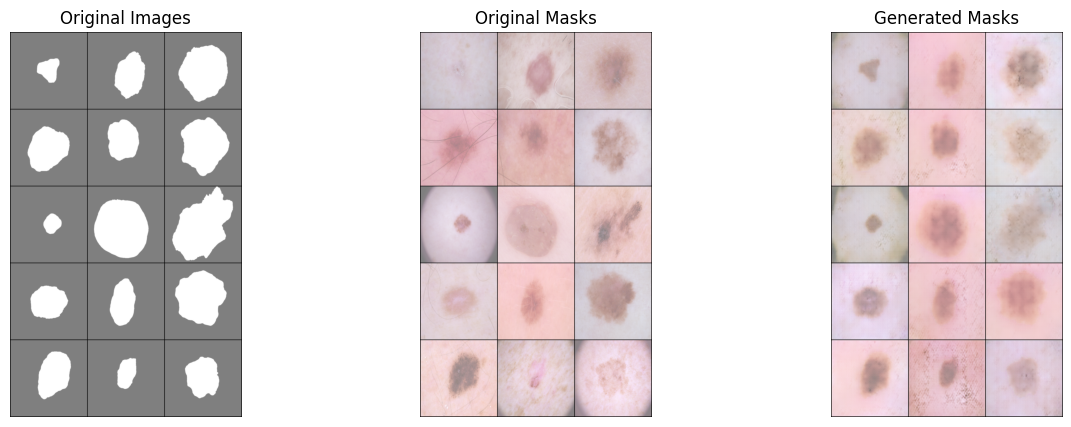

[Epoch 30/100] [Disc loss: 0.844145] [Gen loss: 9.823459]


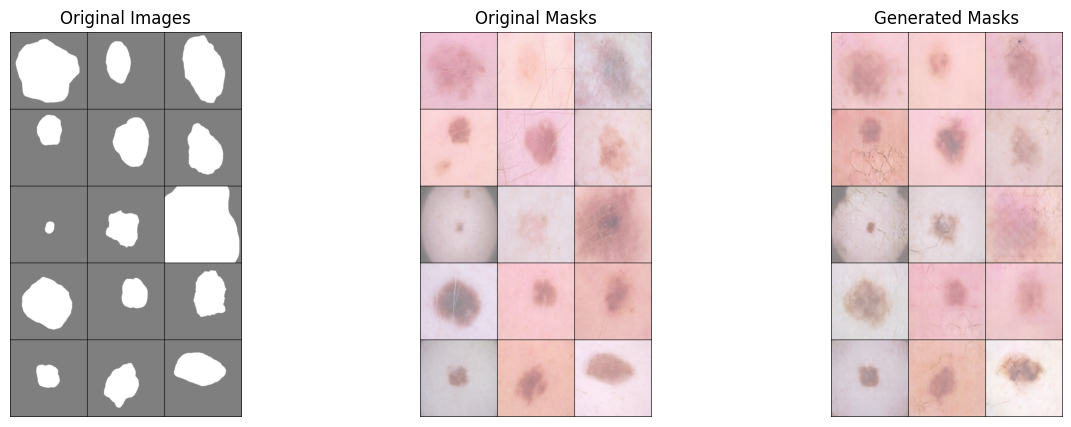

[Epoch 40/100] [Disc loss: 0.724383] [Gen loss: 8.600628]


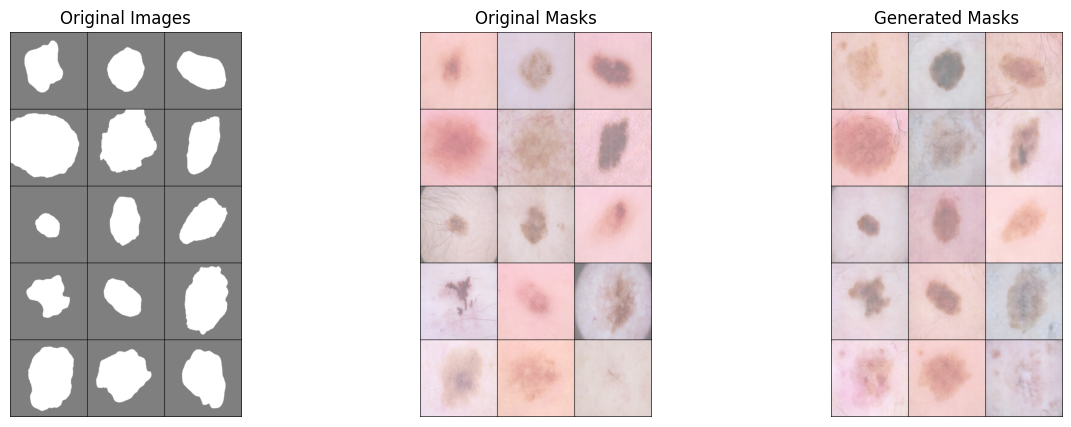

[Epoch 50/100] [Disc loss: 0.668352] [Gen loss: 7.699712]


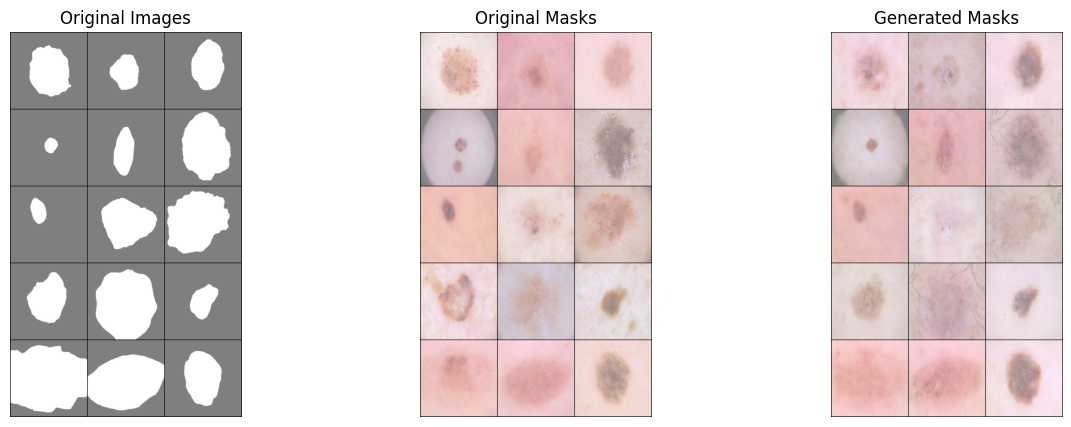

[Epoch 60/100] [Disc loss: 0.607512] [Gen loss: 7.850991]


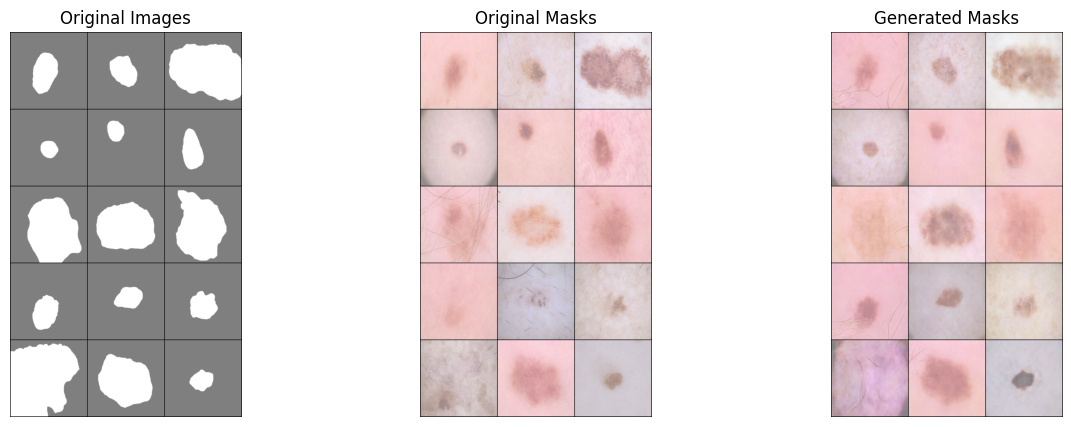

[Epoch 70/100] [Disc loss: 0.502245] [Gen loss: 7.839680]


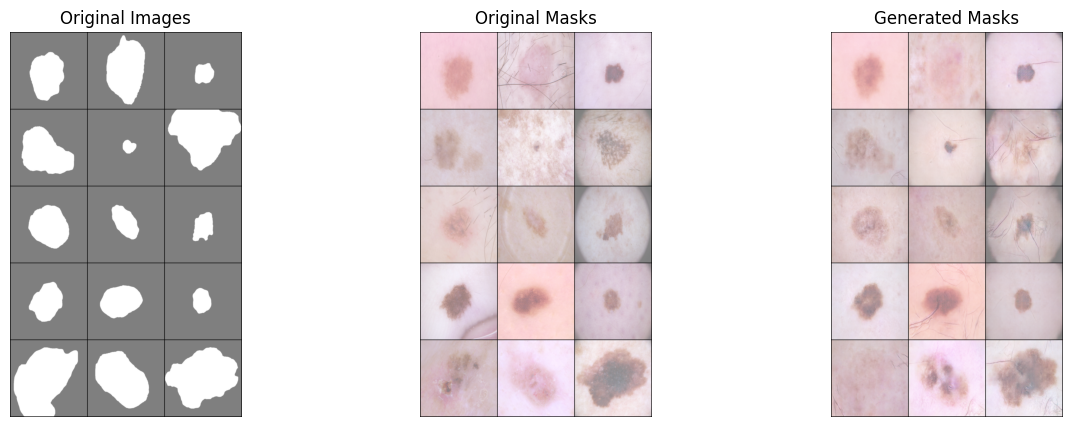

[Epoch 80/100] [Disc loss: 0.593019] [Gen loss: 7.361741]


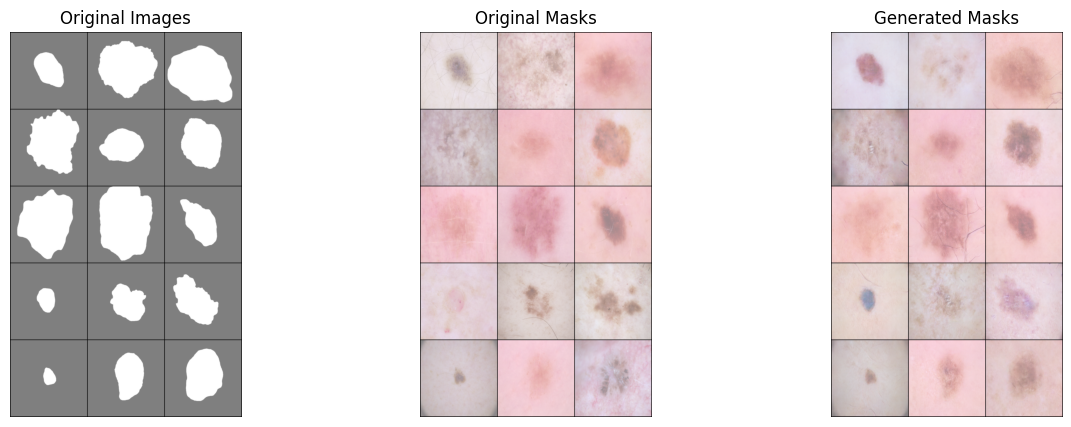

[Epoch 90/100] [Disc loss: 0.540989] [Gen loss: 7.123233]


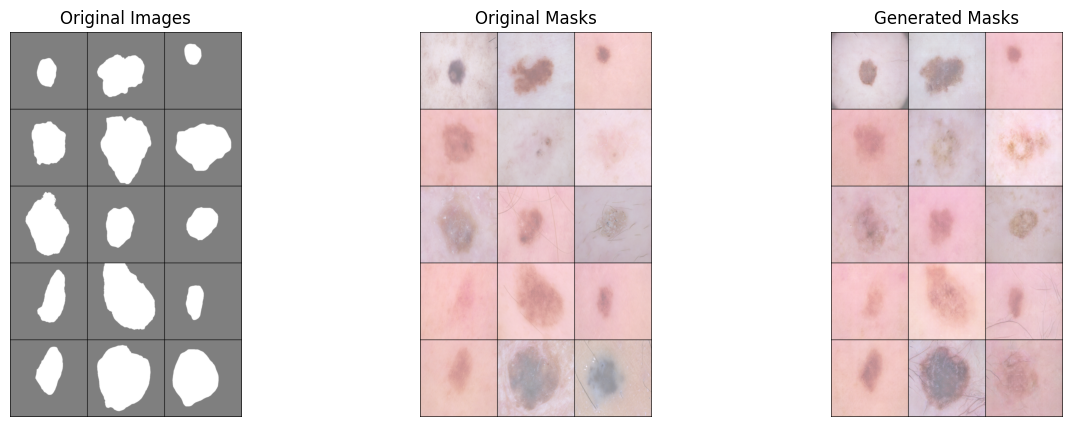

[Epoch 100/100] [Disc loss: 0.481822] [Gen loss: 7.269764]


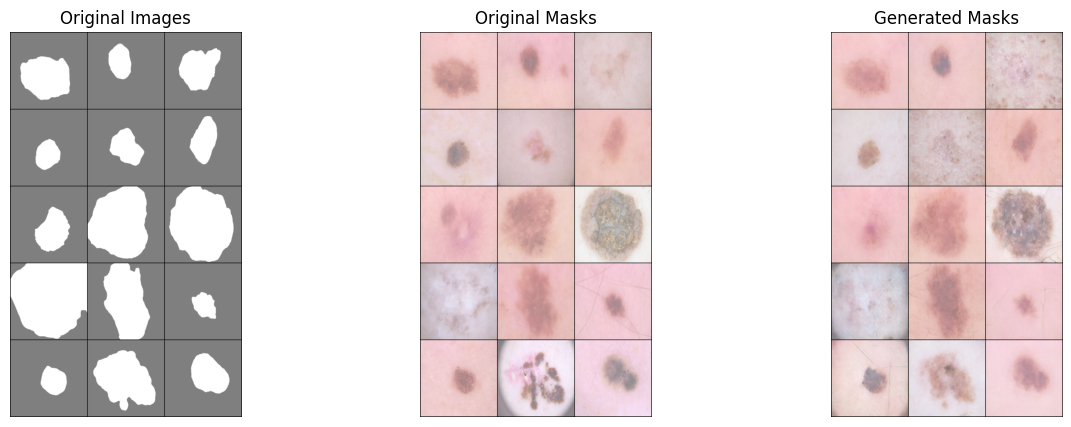

In [22]:
for i in tqdm(range(Epochs)) : 
    for img , mask in dataset_dataloader : 
        img , mask = img.to(device) , mask.to(device) 
        
        # updata discriminator 
        with torch.cuda.amp.autocast() : 
            fake = gen_model(img)
            
            disc_fake_pred = disc_model(img , fake.detach()) 
            disc_real_pred = disc_model(img , mask) 
            
            disc_fake_loss = criterion(disc_fake_pred , torch.zeros_like(disc_fake_pred))
            disc_real_loss = criterion(disc_real_pred , torch.ones_like(disc_real_pred))
            
            disc_loss = (disc_fake_loss + disc_real_loss) / 2 
            
        disc_model.zero_grad()
        d_scaler.scale(disc_loss).backward()
        d_scaler.step(disc_optimizer)
        d_scaler.update()
        
        
        # update Generator 
        with torch.cuda.amp.autocast() : 
            fake2 = gen_model(img) 
            gen_fake_pred = disc_model(img , fake2) 
            
            gen_fake_loss = criterion(gen_fake_pred , torch.ones_like(gen_fake_pred)) 
            
            gen_pixelwise_loss = criterion_pixelwise(fake2 , mask) * lambda_pixel
            
            gen_loss = gen_fake_loss + gen_pixelwise_loss
            
        gen_optimizer.zero_grad() 
        g_scaler.scale(gen_loss).backward()
        g_scaler.step(gen_optimizer) 
        g_scaler.update()
        
    
    if (i+1) % 10 == 0 : 
        print(
                "[Epoch %d/%d] [Disc loss: %f] [Gen loss: %f]"
                % (i+1, Epochs , disc_loss.item(), gen_loss.item())
            )
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        show_tensor_images(axs[0] , img , "Original Images")
        show_tensor_images(axs[1] , mask , "Original Masks")
        show_tensor_images(axs[2] , gen_model(img) , "Generated Masks")
        plt.show()

# Save our model

In [23]:
torch.save(gen_model.state_dict(), 'Skin Cancer Gen Model.pt')

In [24]:
torch.save(disc_model.state_dict(), 'Skin Cancer Disc Model.pt')